ขั้นตอนนี้คือโหลด dataset จากไฟล์ .pt, split แบบป้องกัน leakage (ถ้ามี group), ตรวจ overlap และเทรนโมเดล

In [39]:
import torch

# path ของไฟล์ dataset ที่เตรียมไว้ล่วงหน้า
MODEL_PATH = "/Users/sarawit/Documents/Year2/sem2/Artificial-inteligent/FINAL_PROJECT/CSI_Detection/csi_dataset/csi_windows_w64_s32.pt"

# โหลดข้อมูลจากไฟล์ .pt มาไว้บน CPU ก่อน (ปลอดภัยเวลาเริ่มต้น)
data = torch.load(MODEL_PATH, map_location="cpu")

# X_all = ข้อมูลสัญญาณ CSI, y_all = label ของแต่ละตัวอย่าง
X_all = data["X"]   # expected shape: (N, 64, F)
y_all = data["y"]   # expected shape: (N,)

# เช็คขนาดข้อมูลก่อนนำไป split
print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

X_all shape: torch.Size([173, 32, 53])
y_all shape: torch.Size([173])


In [40]:
import numpy as np

# ดูจำนวนตัวอย่างในแต่ละคลาส เพื่อเช็ค class balance
unique, counts = np.unique(y_all, return_counts=True)
print("classes:", unique)
print("counts :", counts)

classes: [0 1 2]
counts : [21 79 73]


In [41]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import numpy as np

# เป้าหมายสุดท้าย: Train 70% / Val 15% / Test 15%
# ถ้ามี metadata ของกลุ่ม (เช่น session/file/person) จะใช้ GroupShuffleSplit เพื่อลด data leakage
# ถ้าไม่มีกลุ่ม จะ fallback ไป stratified random split แบบเดิม

candidate_group_keys = [
    "group", "groups", "group_id", "session", "session_id",
    "file", "file_id", "record_id", "person_id", "subject_id"
]

# หา key ของ group จาก data ที่โหลดมา
use_group_key = next((k for k in candidate_group_keys if k in data), None)

if use_group_key is not None:
    raw_groups = data[use_group_key]
    groups_all = raw_groups.cpu().numpy() if hasattr(raw_groups, "cpu") else np.asarray(raw_groups)

    if groups_all.shape[0] != len(y_all):
        raise ValueError(f"Group key '{use_group_key}' length={groups_all.shape[0]} does not match y_all length={len(y_all)}")

    print(f"Split mode: GROUP ({use_group_key})")

    # Step 1) แยก Test = 15% ด้วย group split
    idx_all = np.arange(len(y_all))
    y_np = y_all.cpu().numpy() if hasattr(y_all, "cpu") else np.asarray(y_all)

    gss_test = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
    temp_idx, test_idx = next(gss_test.split(idx_all, y_np, groups_all))

    X_temp, X_test = X_all[temp_idx], X_all[test_idx]
    y_temp, y_test = y_all[temp_idx], y_all[test_idx]
    groups_temp = groups_all[temp_idx]

    # Step 2) จาก Temp (85%) แบ่ง Val ให้เป็น 15% ของข้อมูลทั้งหมด => 15/85 ของ Temp
    val_ratio_in_temp = 15 / 85
    idx_temp = np.arange(len(y_temp))
    y_temp_np = y_temp.cpu().numpy() if hasattr(y_temp, "cpu") else np.asarray(y_temp)

    gss_val = GroupShuffleSplit(n_splits=1, test_size=val_ratio_in_temp, random_state=42)
    train_sub_idx, val_sub_idx = next(gss_val.split(idx_temp, y_temp_np, groups_temp))

    X_train, X_val = X_temp[train_sub_idx], X_temp[val_sub_idx]
    y_train, y_val = y_temp[train_sub_idx], y_temp[val_sub_idx]

    # เก็บ group ของแต่ละ split ไว้ใช้ตรวจ leakage ภายหลัง
    groups_train = groups_temp[train_sub_idx]
    groups_val = groups_temp[val_sub_idx]
    groups_test = groups_all[test_idx]

else:
    print("Split mode: STRATIFIED RANDOM (no group key found in data)")

    # Step 1) แยก Test ออกก่อน 15% ของข้อมูลทั้งหมด
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all,
        test_size=0.15,
        random_state=42,
        stratify=y_all
    )

    # Step 2) จากที่เหลือ 85% แบ่ง Train/Val เพื่อให้ได้ 70/15/15
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=15/85,
        random_state=42,
        stratify=y_temp
    )

    # ไม่มีข้อมูล group ในกรณี fallback
    groups_train = None
    groups_val = None
    groups_test = None

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

Train: torch.Size([121, 32, 53])
Val  : torch.Size([26, 32, 53])
Test : torch.Size([26, 32, 53])


In [ ]:
import hashlib
import numpy as np

# ตรวจ leakage แบบง่าย: duplicate ซ้ำข้าม split + group overlap + baseline

def to_numpy(x):
    return x.cpu().numpy() if hasattr(x, "cpu") else np.asarray(x)

def hash_rows(X):
    arr = to_numpy(X).reshape(X.shape[0], -1)
    return {hashlib.md5(row.tobytes()).hexdigest() for row in arr}

h_train = hash_rows(X_train)
h_val = hash_rows(X_val)
h_test = hash_rows(X_test)

print("Exact duplicate overlap")
print("train ∩ val :", len(h_train & h_val))
print("train ∩ test:", len(h_train & h_test))
print("val   ∩ test:", len(h_val & h_test))

if groups_train is not None:
    g_train = set(to_numpy(groups_train).tolist())
    g_val = set(to_numpy(groups_val).tolist())
    g_test = set(to_numpy(groups_test).tolist())

    print()
    print("Group overlap")
    print("train ∩ val :", len(g_train & g_val))
    print("train ∩ test:", len(g_train & g_test))
    print("val   ∩ test:", len(g_val & g_test))

# baseline accuracy ของการทายคลาสที่เยอะที่สุดใน test
_, test_counts = np.unique(to_numpy(y_test), return_counts=True)
majority_baseline = test_counts.max() / test_counts.sum()

print()
print(f"Majority-class baseline (test): {majority_baseline:.4f}")

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader

# เลือก device: ใช้ MPS บน Mac ถ้ามี, ไม่งั้นใช้ CPU
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", DEVICE)

class CSIDataset(Dataset):
    def __init__(self, X, y):
        # แปลง dtype ให้เหมาะกับโมเดลและ loss ของงาน classification
        self.X = X.float()
        self.y = y.long()

    def __len__(self):
        # จำนวนตัวอย่างทั้งหมดใน dataset
        return self.y.shape[0]

    def __getitem__(self, idx):
        # คืนข้อมูลทีละตัวอย่างในรูป (features, label)
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32

# สร้าง dataset และ dataloader สำหรับ train/test
train_ds = CSIDataset(X_train, y_train)
test_ds  = CSIDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))

Device: mps
Train batches: 4
Test  batches: 1


In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

# เลือกอุปกรณ์คำนวณ:
# - ถ้าเครื่อง Mac รองรับ Metal Performance Shaders (MPS) จะใช้ GPU ของ Apple
# - ถ้าไม่รองรับ จะใช้ CPU
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", DEVICE)

class CSIDataset(Dataset):
    def __init__(self, X, y):
        # เก็บข้อมูลเข้า dataset
        # X -> float32 (เหมาะกับ input ของโมเดล)
        # y -> int64/long (เหมาะกับ label ของงาน classification เช่น CrossEntropyLoss)
        self.X = X.float()
        self.y = y.long()

    def __len__(self):
        # จำนวนตัวอย่างทั้งหมด
        return self.y.shape[0]

    def __getitem__(self, idx):
        # คืนตัวอย่างที่ idx เป็นคู่ (features, label)
        return self.X[idx], self.y[idx]

BATCH_SIZE = 32  # จำนวนตัวอย่างต่อ 1 mini-batch

# สร้าง Dataset สำหรับ train/test
train_ds = CSIDataset(X_train, y_train)
test_ds  = CSIDataset(X_test,  y_test)

# สร้าง DataLoader:
# train -> shuffle=True เพื่อสุ่มลำดับทุก epoch ช่วยให้เรียนรู้ดีขึ้น
# test  -> shuffle=False เพื่อประเมินผลแบบคงที่
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# จำนวน batch ต่อ 1 epoch
print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))

Device: mps
Train batches: 4
Test  batches: 1


In [44]:
# สร้าง Dataset แยก train/val/test
train_ds = CSIDataset(X_train, y_train)
val_ds   = CSIDataset(X_val, y_val)
test_ds  = CSIDataset(X_test, y_test)

# สร้าง DataLoader สำหรับ mini-batch training/evaluation
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# แสดงจำนวน batch ของแต่ละชุดข้อมูล
print("Train batches:", len(train_loader))
print("Val   batches:", len(val_loader))
print("Test  batches:", len(test_loader))

Train batches: 4
Val   batches: 1
Test  batches: 1


In [49]:
# กำหนดจำนวนรอบการเทรนทั้งหมด (แก้ NameError: EPOCHS not defined)
EPOCHS = 20

# วนเทรนโมเดลทั้งหมด EPOCHS รอบ
for epoch in range(1, EPOCHS + 1):

    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # ===== TRAIN =====
    for xb, yb in train_loader:
        # ย้าย batch ไป device ที่เลือกไว้ (mps/cpu)
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    epoch_acc = correct / total

    # ===== VALIDATION =====
    model.eval()
    val_correct = 0  # reset ทุก epoch
    val_total = 0    # reset ทุก epoch

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu()
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch:02d} | train_acc={epoch_acc:.4f} | val_acc={val_acc:.4f}")

Epoch 01 | train_acc=1.0000 | val_acc=1.0000
Epoch 02 | train_acc=1.0000 | val_acc=1.0000
Epoch 03 | train_acc=1.0000 | val_acc=1.0000
Epoch 04 | train_acc=1.0000 | val_acc=1.0000
Epoch 05 | train_acc=1.0000 | val_acc=1.0000
Epoch 06 | train_acc=1.0000 | val_acc=1.0000
Epoch 07 | train_acc=1.0000 | val_acc=1.0000
Epoch 08 | train_acc=1.0000 | val_acc=1.0000
Epoch 09 | train_acc=1.0000 | val_acc=1.0000
Epoch 10 | train_acc=1.0000 | val_acc=1.0000
Epoch 11 | train_acc=1.0000 | val_acc=1.0000
Epoch 12 | train_acc=1.0000 | val_acc=1.0000
Epoch 13 | train_acc=1.0000 | val_acc=1.0000
Epoch 14 | train_acc=1.0000 | val_acc=1.0000
Epoch 15 | train_acc=1.0000 | val_acc=1.0000
Epoch 16 | train_acc=1.0000 | val_acc=1.0000
Epoch 17 | train_acc=1.0000 | val_acc=1.0000
Epoch 18 | train_acc=1.0000 | val_acc=1.0000
Epoch 19 | train_acc=1.0000 | val_acc=1.0000
Epoch 20 | train_acc=1.0000 | val_acc=1.0000


In [46]:
# เตรียมตัวแปรไว้เก็บโมเดลที่ได้ผล validation ดีที่สุด
best_val_acc = 0.0
best_state = None

# หมายเหตุ: cell นี้เทียบจากค่า val_acc ล่าสุดใน runtime ปัจจุบัน
if val_acc > best_val_acc:
    best_val_acc = val_acc
    best_state = model.state_dict()

Confusion Matrix:
[[ 3  0  0]
 [ 0 12  0]
 [ 0  0 11]]

Classification Report:

              precision    recall  f1-score   support

    no_human      1.000     1.000     1.000         3
      static      1.000     1.000     1.000        12
    movement      1.000     1.000     1.000        11

    accuracy                          1.000        26
   macro avg      1.000     1.000     1.000        26
weighted avg      1.000     1.000     1.000        26



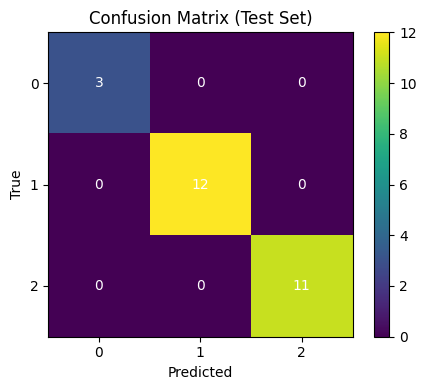

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# โหมดประเมินผล (ปิด dropout/batchnorm update)
model.eval()
all_preds = []
all_true = []

# วิ่ง inference บน test set โดยไม่เก็บ gradient
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_true.extend(yb.numpy())

# แปลงเป็น numpy array เพื่อคำนวณ metric
all_preds = np.array(all_preds)
all_true = np.array(all_true)

# คำนวณ confusion matrix และ classification report
cm = confusion_matrix(all_true, all_preds, labels=[0,1,2])
print("Confusion Matrix:")
print(cm)
print()
print("Classification Report:")
print()
print(classification_report(all_true, all_preds, digits=3, target_names=["no_human","static","movement"]))

# วาด confusion matrix เป็น heatmap
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="viridis")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="white")

plt.xticks([0,1,2], [0,1,2])
plt.yticks([0,1,2], [0,1,2])
plt.tight_layout()
plt.show()
